# Getting a deeper unterstanding for CNNs with Tensorflow and Keras

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Installation of required libs Scikit Learn, TensorFlow, and Keras

In [38]:
!conda install --name root scikit-learn -y

Fetching package metadata .......
Solving package specifications: ..........

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-env-2.6.0            |                0          502 B

The following packages will be UPDATED:

    conda:     4.2.13-py35_0 conda-forge --> 4.3.16-py35_0

The following packages will be SUPERCEDED by a higher-priority channel:

    conda-env: 2.6.0-0       conda-forge --> 2.6.0-0      

Pruning fetched packages from the cache ...
Fetching packages ...
conda-env-2.6. 100% |################################| Time: 0:00:00 729.57 kB/s
Extracting packages ...
[      COMPLETE      ]|###################################################| 100%
Unlinking packages ...
[      COMPLETE      ]|###################################################| 100%
Linking packages ...
[      COMPLETE      ]|##

In [39]:
from distutils.version import StrictVersion

In [40]:
import sklearn

# should at least be 0.18
assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

sklearn.__version__

'0.18.1'

In [41]:
!conda install --name root -c conda-forge tensorflow -y

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following packages will be SUPERSEDED by a higher-priority channel:

    conda:     4.3.16-py35_0 --> 4.2.13-py35_0 conda-forge
    conda-env: 2.6.0-0       --> 2.6.0-0       conda-forge

conda-env-2.6. 100% |################################| Time: 0:00:00   1.21 MB/s


In [42]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# should at least be 1.0
assert StrictVersion(tf.__version__) >= StrictVersion('1.0.0')

tf.__version__

'1.0.0'

In [43]:
!pip install keras

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [44]:
import keras as keras

# should at least be 1.2 and use TensorFlow backend
assert StrictVersion(keras.__version__) >= StrictVersion('1.2.2')

keras.__version__

'2.0.3'

# Big Kudos to [Waleed Abdulla](https://medium.com/@waleedka) for providing the initial idea and many of the functions used to prepare and display the images: https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.i728o84ib  

## Download data

In [45]:
# https://notebooks.azure.com/faq#service_restrictions
# https://notebooks.azure.com/faq#upload_data
# https://notebooks.azure.com/n/xwZx1vmIroU/notebooks/Getting%20to%20your%20Data%20in%20Azure%20Notebooks.ipynb

In [46]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1810k  100 1810k    0     0  3182k      0 --:--:-- --:--:-- --:--:-- 3186k


In [47]:
# https://docs.python.org/3/library/zipfile.html
from zipfile import ZipFile
zip = ZipFile(r'speed-limit-signs.zip')
zip.extractall('.')

In [48]:
!ls -l speed-limit-signs

total 28
drwxr-xr-x 2 nbuser nbuser 4096 Apr 23 09:03 0
drwxr-xr-x 2 nbuser nbuser 4096 Apr 23 09:03 1
drwxr-xr-x 2 nbuser nbuser 4096 Apr 23 09:03 2
drwxr-xr-x 2 nbuser nbuser 4096 Apr 23 09:03 3
drwxr-xr-x 2 nbuser nbuser 4096 Apr 23 09:03 4
drwxr-xr-x 2 nbuser nbuser 4096 Apr 23 09:03 5
-rw-r--r-- 1 nbuser nbuser  380 Apr 23 09:28 README.md


In [49]:
!cat speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

In [50]:
!ls speed-limit-signs/0

00000.ppm  00012.ppm  00024.ppm  00036.ppm  00048.ppm  00060.ppm  00072.ppm
00001.ppm  00013.ppm  00025.ppm  00037.ppm  00049.ppm  00061.ppm  00073.ppm
00002.ppm  00014.ppm  00026.ppm  00038.ppm  00050.ppm  00062.ppm  00074.ppm
00003.ppm  00015.ppm  00027.ppm  00039.ppm  00051.ppm  00063.ppm  00075.ppm
00004.ppm  00016.ppm  00028.ppm  00040.ppm  00052.ppm  00064.ppm  00076.ppm
00005.ppm  00017.ppm  00029.ppm  00041.ppm  00053.ppm  00065.ppm  00077.ppm
00006.ppm  00018.ppm  00030.ppm  00042.ppm  00054.ppm  00066.ppm  00078.ppm
00007.ppm  00019.ppm  00031.ppm  00043.ppm  00055.ppm  00067.ppm
00008.ppm  00020.ppm  00032.ppm  00044.ppm  00056.ppm  00068.ppm
00009.ppm  00021.ppm  00033.ppm  00045.ppm  00057.ppm  00069.ppm
00010.ppm  00022.ppm  00034.ppm  00046.ppm  00058.ppm  00070.ppm
00011.ppm  00023.ppm  00035.ppm  00047.ppm  00059.ppm  00071.ppm


## Analyse and Prepare Image Data

In [51]:
import os
import skimage.data

def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [52]:
# Load datasets.
ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")

images, labels = load_data(data_dir)

In [53]:
len(set(labels)), len(images)

(6, 379)

In [54]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

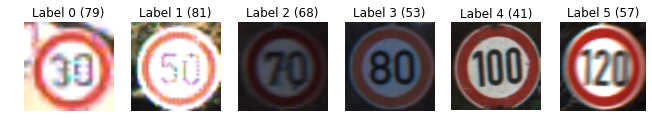

In [55]:
display_images_and_labels(images, labels)

In [56]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (61, 58, 3), min: 3, max: 255
shape: (24, 28, 3), min: 17, max: 199
shape: (24, 27, 3), min: 11, max: 120
shape: (25, 26, 3), min: 11, max: 84
shape: (25, 25, 3), min: 11, max: 113


In [57]:
import skimage.transform

# Resize images
images64 = [skimage.transform.resize(image, (64, 64))
                for image in images]

In [58]:
for image in images64[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (64, 64, 3), min: 0.015943818933823108, max: 1.0
shape: (64, 64, 3), min: 0.06666666666666667, max: 0.7640548406862744
shape: (64, 64, 3), min: 0.043137254901960784, max: 0.4625248927696077
shape: (64, 64, 3), min: 0.043137254901960784, max: 0.32139102711397066
shape: (64, 64, 3), min: 0.043137254901960784, max: 0.4333871878829663


In [59]:
import numpy as np

y = np.array(labels)
X = np.array(images64)
y.shape, X.shape

((379,), (379, 64, 64, 3))

# End of Step 2

## Training a simple Keras model

In [61]:
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

### Starting with one fully connected layer and a softmax output

In [62]:
# https://keras.io/getting-started/functional-api-guide/
from keras.models import Model
from keras.layers import Dense, Flatten, Input

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

x = Dense(256, activation='relu')(inputs)
x = Flatten()(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(input=inputs, output=predictions)

In [63]:
model.input_shape

(None, 64, 64, 3)

In [64]:
model.output_shape

(None, 6)

### Keras Models need to be compiled (to TensorFlow in our case) before usage

In [65]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### First let make a sense check of the architecture, will it be sufficient? To do so try to overfit it with a very small set of data: http://cs231n.github.io/neural-networks-3/#sanitycheck

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
# http://cs231n.github.io/neural-networks-3/#sanitycheck
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=3)

In [70]:
# we are only interested in the training data (0.5 % of ~400 = ~20)
X_train.shape, y_train.shape

((18, 64, 64, 3), (18, 6))

In [72]:
# smaller batch sizes might lead to overfitting: https://twitter.com/tomordonez/status/854832345823707137?s=03
model.fit(X_train, y_train, nb_epoch=100, batch_size=100)

Epoch 1/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 2/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 3/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 4/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 5/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 6/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 7/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 8/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 9/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 10/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 11/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 12/100
18/18 [==============================] 

### Nope, not good, stuck at low accuracy: if we can not even perfectly match the very small test data, probably not a good model

### Let's try 4 times as many neurons, because it might work: http://cs231n.github.io/neural-networks-1/#power

In [73]:
from keras.models import Model
from keras.layers import Dense, Flatten, Input

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

x = Dense(1024, activation='relu')(inputs)
x = Flatten()(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, nb_epoch=100, batch_size=100)

Epoch 1/100
18/18 [==============================] - 1s - loss: 1.7865 - acc: 0.2778
Epoch 2/100
18/18 [==============================] - 0s - loss: 8.2517 - acc: 0.3333
Epoch 3/100
18/18 [==============================] - 0s - loss: 10.8142 - acc: 0.2222
Epoch 4/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 5/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 6/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 7/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 8/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 9/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 10/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 11/100
18/18 [==============================] - 0s - loss: 13.4317 - acc: 0.1667
Epoch 12/100
18/18 [==============================] - 

### Same problem, what about a second hidden layer, because pratically more than on layer makes training feasible in the first place

In [74]:
from keras.models import Model
from keras.layers import Dense, Flatten, Input

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

x = Dense(512, activation='relu')(inputs)
x = Dense(512, activation='relu')(x)
x = Flatten()(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, nb_epoch=30, batch_size=100)

Epoch 1/30
18/18 [==============================] - 1s - loss: 1.7891 - acc: 0.1111
Epoch 2/30
18/18 [==============================] - 1s - loss: 8.9505 - acc: 0.3333
Epoch 3/30
18/18 [==============================] - 1s - loss: 9.1739 - acc: 0.2778
Epoch 4/30
18/18 [==============================] - 1s - loss: 10.8446 - acc: 0.1667
Epoch 5/30
18/18 [==============================] - 1s - loss: 12.1566 - acc: 0.1667
Epoch 6/30
18/18 [==============================] - 1s - loss: 2.5649 - acc: 0.1667
Epoch 7/30
18/18 [==============================] - 1s - loss: 2.9159 - acc: 0.3889
Epoch 8/30
18/18 [==============================] - 1s - loss: 5.4452 - acc: 0.3889
Epoch 9/30
18/18 [==============================] - 1s - loss: 2.8060 - acc: 0.1667
Epoch 10/30
18/18 [==============================] - 1s - loss: 1.4264 - acc: 0.4444
Epoch 11/30
18/18 [==============================] - 1s - loss: 1.1579 - acc: 0.5556
Epoch 12/30
18/18 [==============================] - 1s - loss: 3.3090 -

### Wow, same amount of neurons, but now we can actually overfit, and have 100% accuracy

In [75]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=32)
train_loss, train_accuracy

18/18 [==============================] - 0s


(0.011965927667915821, 1.0)

### But on unknown data of course we totally suck (might be as low as 30%)

In [76]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
test_loss, test_accuracy

361/361 [==============================] - 8s     


(3.8304215058725628, 0.27146814408559877)

### This bad result was to be expected, because we were overfitting on purpose, now take a more reasonable split and try not to overfit too much

### Split training (80%) from test data (%20) (and make it reproduceable)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### Training now takes far longer, as we have far more data, even on a very powerful machine, this might take up to 15 minutes, do not run this, unless you have time and a big machine

In [78]:
from keras.models import Model
from keras.layers import Dense, Flatten, Input

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

# reduced to make this terminate in a reasonable amout of time
x = Dense(128, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
# x = Dense(512, activation='relu')(inputs)
# x = Dense(512, activation='relu')(x)
x = Flatten()(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# comment it in again if you really want to give it a try...
# model.fit(X_train, y_train, nb_epoch=30, batch_size=100)

Epoch 1/30
303/303 [==============================] - 3s - loss: 7.9030 - acc: 0.2079     
Epoch 2/30
303/303 [==============================] - 3s - loss: 5.1308 - acc: 0.2310     
Epoch 3/30
303/303 [==============================] - 3s - loss: 2.1317 - acc: 0.2739     
Epoch 4/30
303/3

In [80]:
# if accuracy is still not close to 1, run this as many times as necessary 
model.fit(X_train, y_train, nb_epoch=10, batch_size=100)

Epoch 1/10
303/303 [==============================] - 3s - loss: 0.1628 - acc: 0.9769     
Epoch 2/10
303/303 [==============================] - 3s - loss: 0.1287 - acc: 0.9802     
Epoch 3/10
303/303 [==============================] - 3s - loss: 0.8020 - acc: 0.8119     
Epoch 4/10
303/3

In [81]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=32)
train_loss, train_accuracy

303/303 [==============================] - 1s     


(0.049549342345188159, 0.99669966996699666)

In [82]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
test_loss, test_accuracy

64/76 [========================>.....] - ETA: 0s

(0.7570538050250003, 0.69736842105263153)

### This takes a lot of time to train, and still sucks on test data, can we do better?

# End of Step 3

### Turns out we can use a standard CNN model with many more layers, but far less neurons

In [83]:
# VGG related, pretty standard architecture, not very deep
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

# a layer instance is callable on a tensor, and returns a tensor
x = Convolution2D(32, 4, 4, border_mode='same', activation='relu')(inputs)
x = Convolution2D(32, 4, 4, border_mode='same', activation='relu')(x)
x = Convolution2D(32, 4, 4, border_mode='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Convolution2D(64, 4, 4, border_mode='same', activation='relu')(x)
x = Convolution2D(64, 4, 4, border_mode='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.50)(x)

predictions = Dense(6, activation='softmax')(x)

# this creates a model that includes
# the Input layer and three Dense layers
model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, nb_epoch=50, batch_size=100)

Epoch 1/30
303/303 [==============================] - 7s - loss: 2.6438 - acc: 0.1617     
Epoch 2/30
303/303 [==============================] - 7s - loss: 1.7631 - acc: 0.2211     
Epoch 3/30
303/303 [==============================] - 6s - loss: 1.8695 - acc: 0.2079     
Epoch 4/30
303/3

In [86]:
# again, if accuracy is still not close to 1, run this as many times as necessary 
model.fit(X_train, y_train, nb_epoch=10, batch_size=100)

Epoch 1/10
303/303 [==============================] - 6s - loss: 0.0512 - acc: 0.9835     
Epoch 2/10
303/303 [==============================] - 6s - loss: 0.0328 - acc: 0.9967     
Epoch 3/10
303/303 [==============================] - 6s - loss: 0.0370 - acc: 0.9901     
Epoch 4/10
303/3

In [87]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=32)
train_loss, train_accuracy

303/303 [==============================] - 1s     


(0.0012501420002897876, 1.0)

In [89]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
test_loss, test_accuracy

76/76 [==============================] - 0s     


(0.92604654713680867, 0.88157895050550761)

## Might be up to 90% accuracy on Test Data, great result

### Let us try a few random samples on the test data

In [90]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

In [92]:
sample_labels

[array([ 0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.])]

In [93]:
# that is a tad hard to read, just choose the category

ground_truth = np.argmax(sample_labels, axis=1)
ground_truth

array([1, 5, 5, 0, 4, 4, 5, 2, 1, 5])

In [94]:
# now make the prediction for the sample inputs
X_sample = np.array(sample_images)
prediction = model.predict(X_sample)

In [95]:
# softmax predictions would be even harder to read, again just choose the hightst category

predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([1, 5, 5, 0, 4, 4, 5, 2, 5, 5])

In [96]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

## Visualizing where we were right (might be up to 9 out of 10)

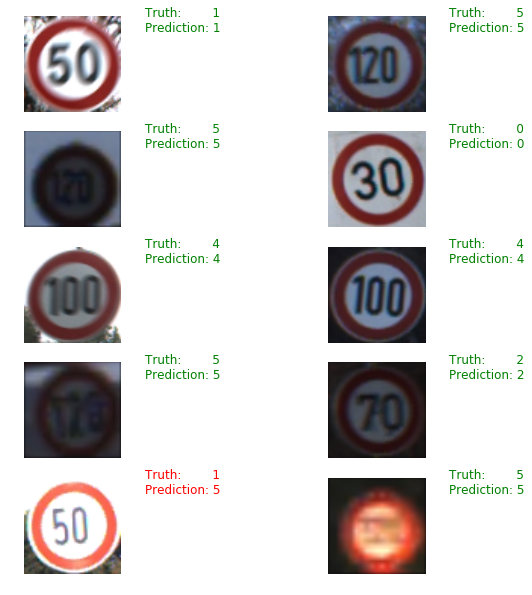

In [97]:
display_prediction(sample_images, ground_truth, predicted_categories)

## Save model for later predictions and comparions

In [98]:
!mkdir models

In [99]:
model.save('models/conv-vgg.h5')

In [100]:
# use the Data Menu Item to download from this directory
!ls -l models

total 33868
-rw-r--r-- 1 nbuser nbuser 34676904 Apr 23 10:08 conv-vgg.h5


In [101]:
# https://notebooks.azure.com/faq#download_data
# or use https://transfer.sh/
!curl --upload-file ./models/conv-vgg.h5 https://transfer.sh/conv-vgg.h5

https://transfer.sh/xjzxH/conv-vgg.h5

Comparing optimizations:

![RmsProp](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/opt1.gif)